# CD7: full spectrum dimensionality reduction of neutrophils

In this notebook, we perform a clustering analysis of the CD7 data on features extracted from SCIP.

In [2]:
%load_ext autoreload
%autoreload 2

In [21]:
import warnings

In [2]:
from scip_workflows.common import *

In [7]:
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif
from sklearn.preprocessing import scale
import anndata
import scanpy
scanpy.settings.verbosity = 3

from sklearn.preprocessing import scale
import flowutils

import scipy.stats
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import squareform

from kneed import KneeLocator

In [8]:
from scip.features import intensity
props = intensity.props.copy()
props.remove("kurtosis")
props.remove("skewness")

In [9]:
def asinh_scale(x, t):
    return scale(flowutils.transforms.asinh(x, channel_indices=None, t=t, m=4.5, a=1), with_std=False)

In [10]:
plt.rcParams['figure.dpi'] = 150

## Data

In [11]:
try:
    data_dir = Path(snakemake.input.data_dir)
except NameError:
    data_dir = Path("/data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/results/scip/202203221745/")
    data_dir = Path("/home/maximl/scratch/data/vsc/datasets/cd7/800/results/scip/202203221745")

In [14]:
df = pq.read_table(data_dir / "features.parquet").to_pandas()
df = df[numpy.load(data_dir / "indices/columns.npy", allow_pickle=True)]

df = df.set_index(["meta_panel", "meta_replicate", "meta_P", "meta_id"])
df = df.loc["D"]
df = df.loc[numpy.load(data_dir / "indices/index_v2.npy", allow_pickle=True)]
df = df.sort_index()

df.shape

(34640, 832)

In [29]:
obs = df.filter(regex='meta').reset_index()
obs.index = df.index
adata = anndata.AnnData(df.filter(regex="feat").astype(numpy.float32), obs=obs)

adata.obs["meta_replicate"] = adata.obs["meta_replicate"].astype("category")

In [30]:
markers = [col for col in adata.var.index if col.startswith("feat_sum")]

## Removing zero variance features

from sklearn.feature_selection import VarianceThreshold

In [31]:
var = VarianceThreshold().fit(adata.X)

In [32]:
adata = adata[:, var.get_support()].copy()

## Analysis

In [19]:
adata_pre = adata.copy()

computing PCA
    with n_comps=50
    finished (0:00:06)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:07)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:30)


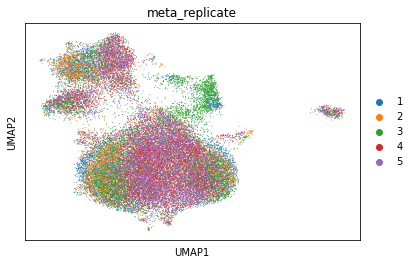

CPU times: user 5min 36s, sys: 2min 42s, total: 8min 19s
Wall time: 2min 46s


In [20]:
%%time
scanpy.pp.scale(adata_pre)
scanpy.tl.pca(adata_pre, svd_solver='arpack')
scanpy.pp.neighbors(adata_pre, n_neighbors=30)
scanpy.tl.umap(adata_pre)
scanpy.pl.umap(adata_pre, color=["meta_replicate"])

In [23]:
discrete = ["median", "area", "euler"]
discrete_cols = [c for c in adata.var_names if any(d in c for d in discrete)]
discrete_cols_i = [i for i, c in enumerate(adata.var_names) if any(d in c for d in discrete)]

In [25]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    mi = mutual_info_classif(X=adata_pre.X, y=adata_pre.obs["meta_replicate"].values, discrete_features=discrete_cols_i, n_neighbors=30, random_state=0)
    mi = pandas.Series(mi, index=adata_pre.var_names).sort_values(ascending=False)

CPU times: user 6min 45s, sys: 1.17 s, total: 6min 47s
Wall time: 6min 51s


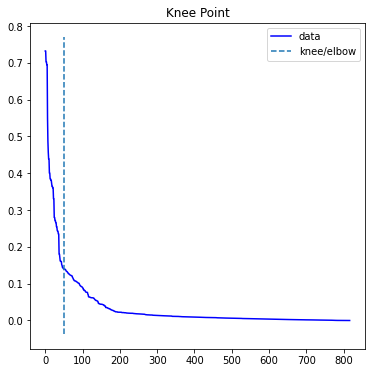

In [26]:
kneedle = KneeLocator(numpy.arange(len(mi)), mi, S=1, curve='convex', direction="decreasing",online=False)
elbow_value = mi.iloc[int(kneedle.knee)]

kneedle.plot_knee()

In [27]:
mi.median()

0.00903553952994951

In [33]:
adata.var["is_marker"] = [any(n.endswith("feat_sum_%s" % m) for m in ["DAPI", "EGFP", "RPe", "APC"]) for n in adata.var_names]
adata.var["do_asinh"] = [(any(m in n for m in ["DAPI", "EGFP", "RPe", "APC"]) and any(o in n for o in props)) for n in adata.var_names]

In [34]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    sc_df = scanpy.get.obs_df(adata, keys=adata.var_names.to_list())
    sc_df[adata.var_names[adata.var.do_asinh].to_list()] = sc_df[adata.var_names[adata.var.do_asinh]].groupby(["meta_replicate", "meta_P"]).transform(lambda x: asinh_scale(x, x.max()))
    sc_df[adata.var_names[~adata.var.do_asinh].to_list()] = sc_df[adata.var_names[~adata.var.do_asinh]].groupby(["meta_replicate", "meta_P"]).transform(lambda x: scale(x))

adata = anndata.AnnData(X=sc_df, obs=adata.obs, var=adata.var)

CPU times: user 2min 26s, sys: 53.8 s, total: 3min 20s
Wall time: 3min 24s


In [35]:
def map_names(a):
    return {
        "feat_sum_DAPI": "DAPI",
        "feat_sum_EGFP": "CD45",
        "feat_sum_RPe": "Siglec 8",
        "feat_sum_APC": "CD15"
    }[a]

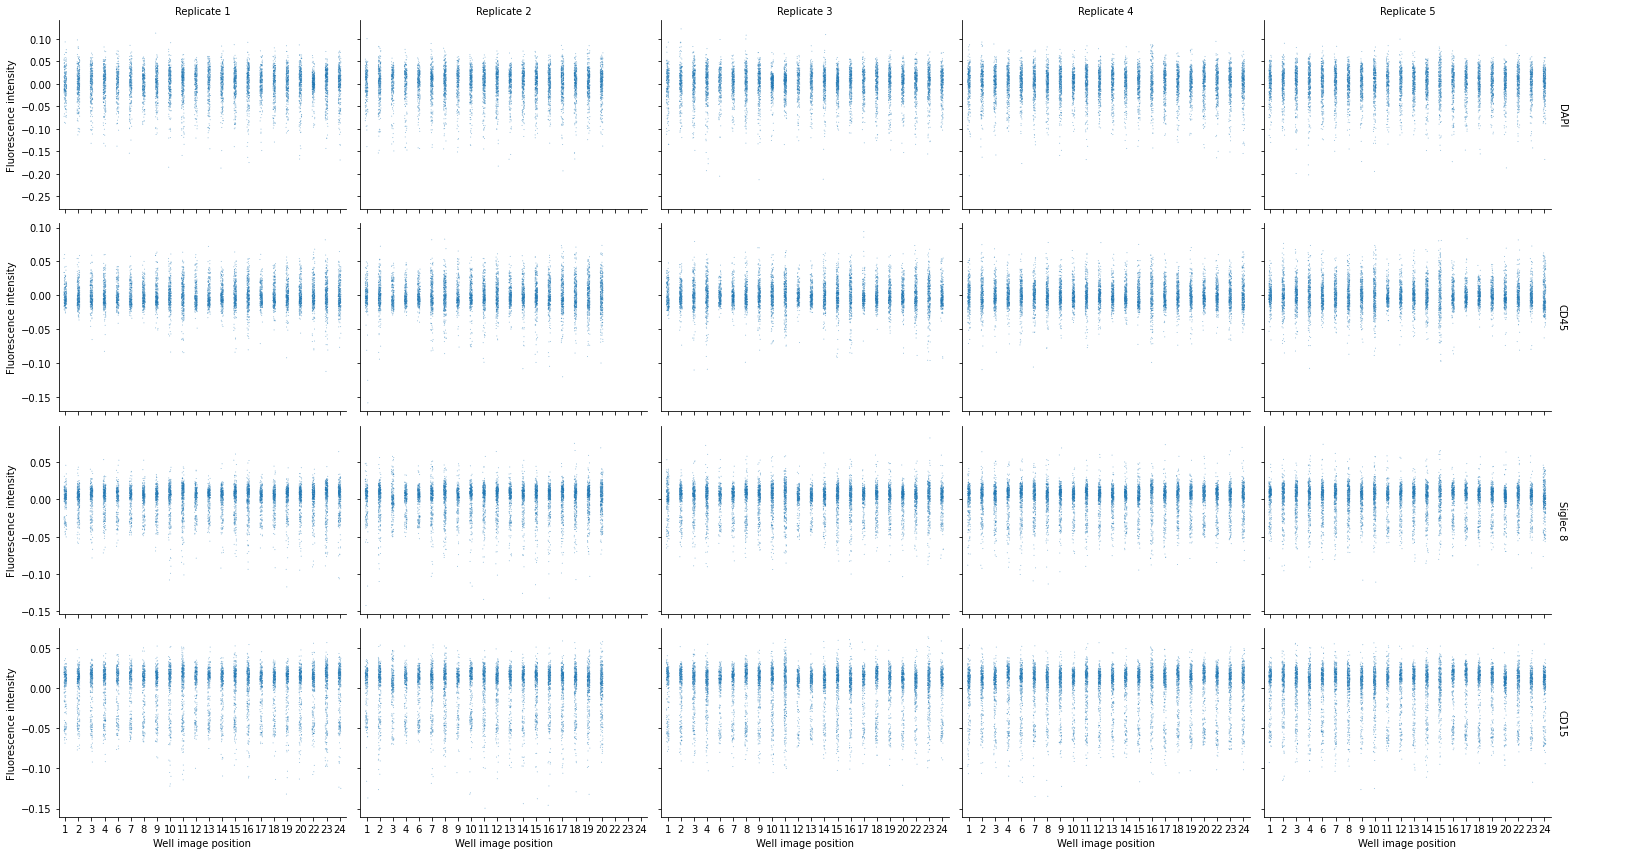

In [36]:
aligned_df = scanpy.get.obs_df(adata, keys=adata.var_names[adata.var.is_marker].to_list()).reset_index()

melted_df = pandas.melt(aligned_df, id_vars=["meta_P", "meta_replicate"], value_vars=adata.var_names[adata.var.is_marker].to_list())
melted_df.variable = melted_df.variable.apply(map_names)

grid = seaborn.FacetGrid(data=melted_df, col="meta_replicate", row="variable", sharey="row", aspect=1.5, margin_titles=True)
grid.map_dataframe(seaborn.stripplot, x="meta_P", y="value", size=1, alpha=0.5)

grid.set_axis_labels("Well image position", "Fluorescence intensity")
grid.set_titles(col_template="Replicate {col_name}", row_template="{row_name}")

grid.add_legend()

# plt.savefig(data_dir / "figures/qc_intensity_distribution_post.png", bbox_inches='tight', pad_inches=0)

In [37]:
def rediscritize(v):
    bin_idx = numpy.digitize(v, bins=numpy.histogram_bin_edges(v))
    bin2mu = [numpy.mean(v[bin_idx == i]) for i in range(1, numpy.max(bin_idx)+1)]
    return numpy.fromiter((bin2mu[i-1] for i in bin_idx), dtype=float)

In [38]:
X = adata.X.copy()
X[:, discrete_cols_i] = numpy.apply_along_axis(rediscritize, 0, X[:, discrete_cols_i])

/srv/scratch/maximl/miniconda3/envs/scip/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/srv/scratch/maximl/miniconda3/envs/scip/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [39]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    mi_post = mutual_info_classif(X=X, y=adata.obs["meta_replicate"], discrete_features=discrete_cols_i, n_neighbors=30, random_state=0)
    mi_post = pandas.Series(mi_post, index=adata.var_names).sort_values(ascending=False)

CPU times: user 6min 45s, sys: 1.96 s, total: 6min 47s
Wall time: 6min 53s


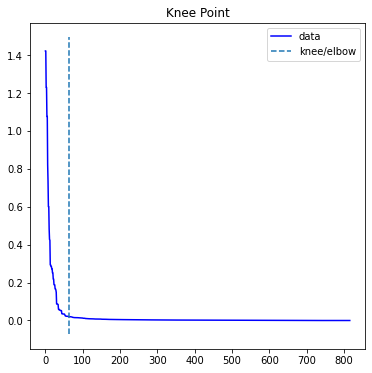

In [42]:
kneedle = KneeLocator(numpy.arange(len(mi_post)), mi_post, S=40, curve='convex', direction="decreasing",online=False)
elbow_value = mi_post.iloc[int(kneedle.knee)]

kneedle.plot_knee()

In [43]:
selected_mi = mi_post[mi_post < elbow_value].index.values
len(selected_mi) / len(mi_post)

0.9216646266829865

In [44]:
mi_post[mi_post > elbow_value].index.values

array(['feat_sobel_min_RPe', 'feat_combined_sobel_min_RPe',
       'feat_combined_mad_RPe', 'feat_mad_RPe', 'feat_edge_mad_RPe',
       'feat_combined_edge_mad_RPe', 'feat_moments_hu-4_combined',
       'feat_moments_hu-6_combined', 'feat_sobel_min_APC',
       'feat_combined_sobel_min_APC', 'feat_moments_hu-4_DAPI',
       'feat_moments_hu-6_DAPI', 'feat_moments_hu-5_combined',
       'feat_combined_min_RPe', 'feat_min_RPe', 'feat_edge_min_RPe',
       'feat_combined_edge_min_RPe', 'feat_lower_quartile_RPe',
       'feat_combined_lower_quartile_RPe',
       'feat_combined_edge_lower_quartile_RPe',
       'feat_edge_lower_quartile_RPe', 'feat_combined_upper_quartile_RPe',
       'feat_upper_quartile_RPe', 'feat_moments_hu-5_DAPI',
       'feat_combined_sobel_min_EGFP', 'feat_sobel_min_EGFP',
       'feat_combined_edge_upper_quartile_RPe',
       'feat_edge_upper_quartile_RPe', 'feat_combined_sobel_min_DAPI',
       'feat_moments_hu-3_combined', 'feat_mad_APC',
       'feat_combined_mad

In [45]:
adata2 = adata[:, selected_mi].copy()

In [46]:
scanpy.pp.scale(adata2)
scanpy.tl.pca(adata2, svd_solver='arpack')
scanpy.pp.neighbors(adata2, n_neighbors=30, method="umap")

computing PCA
    with n_comps=50
    finished (0:00:05)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:19)


In [48]:
%%time
resolutions = [0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 2]
for res in resolutions:
    scanpy.tl.leiden(adata2, resolution=res, key_added=f"leiden_{res}")

running Leiden clustering
    finished: found 3 clusters and added
    'leiden_0.1', the cluster labels (adata.obs, categorical) (0:00:07)
running Leiden clustering
    finished: found 3 clusters and added
    'leiden_0.25', the cluster labels (adata.obs, categorical) (0:00:09)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden_0.5', the cluster labels (adata.obs, categorical) (0:00:22)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden_0.75', the cluster labels (adata.obs, categorical) (0:00:37)
running Leiden clustering
    finished: found 11 clusters and added
    'leiden_1', the cluster labels (adata.obs, categorical) (0:00:38)
running Leiden clustering
    finished: found 13 clusters and added
    'leiden_1.25', the cluster labels (adata.obs, categorical) (0:00:39)
running Leiden clustering
    finished: found 16 clusters and added
    'leiden_1.5', the cluster labels (adata.obs, categorical) (0:00:43)
running Leiden cluster

In [49]:
scanpy.tl.umap(adata2)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:31)


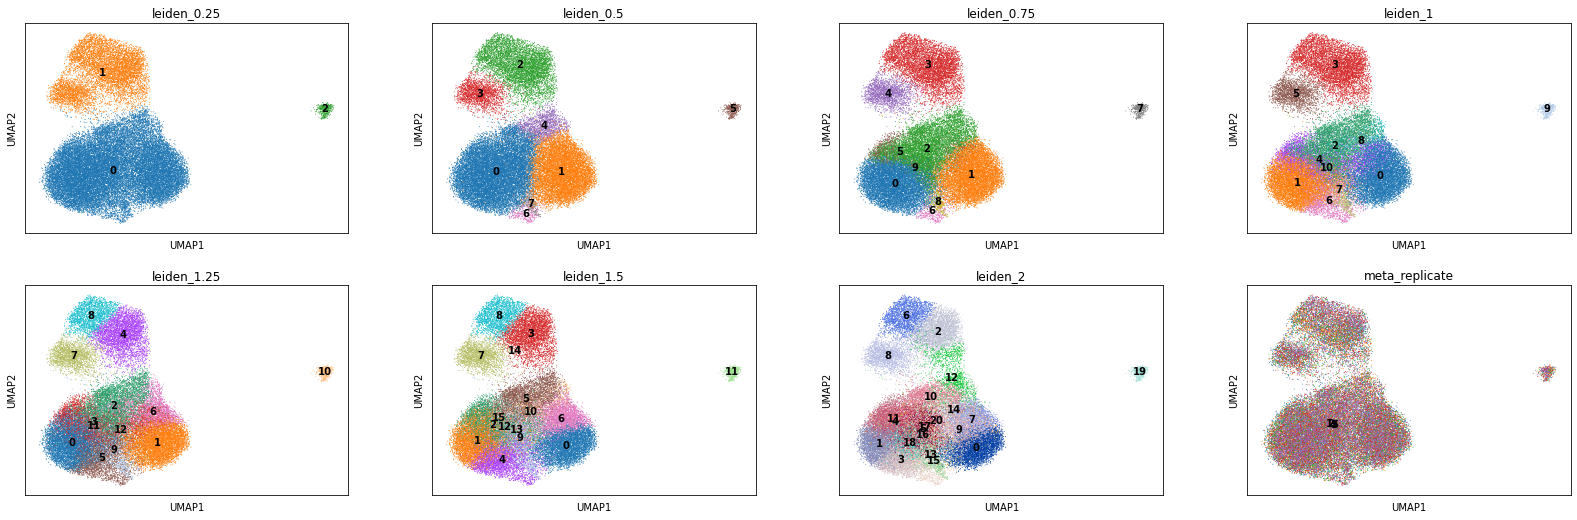

In [50]:
scanpy.pl.umap(adata2, color=["leiden_0.25", "leiden_0.5", "leiden_0.75", "leiden_1", "leiden_1.25", "leiden_1.5", "leiden_2", "meta_replicate"], legend_loc='on data')

In [51]:
adata2.obs["leiden"] = adata2.obs["leiden_0.5"]

<AxesSubplot:xlabel='leiden', ylabel='count'>

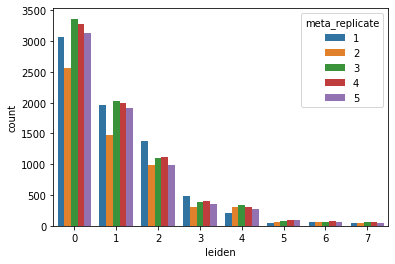

In [52]:
seaborn.countplot(data=adata2.obs, x="leiden", hue="meta_replicate")

In [53]:
markers = [col for col in adata2.var_names if col.startswith(tuple("feat_sum_%s" % m for m in ("EGFP", "RPe", "APC", "DAPI")))]

In [54]:
scanpy.tl.dendrogram(adata2, groupby="leiden")

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


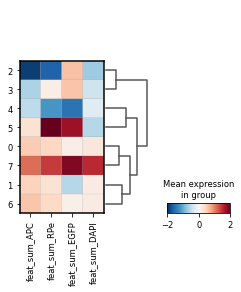

In [55]:
scanpy.pl.matrixplot(adata2, markers, groupby='leiden', dendrogram=True, vmin=-2, vmax=2, cmap='RdBu_r')

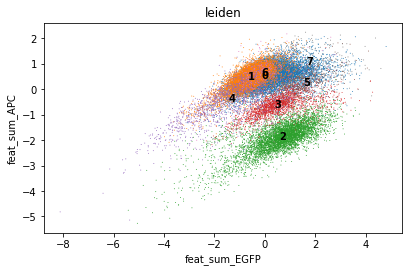

In [56]:
scanpy.pl.scatter(adata2, x="feat_sum_EGFP", y="feat_sum_APC", color="leiden", legend_loc="on data")

In [57]:
# create a dictionary to map cluster to annotation label
cluster2annotation = {
    '0': 'neutrophils',
    '1': 'neutrophils',
    '4': 'neutrophils',
    '6': 'neutrophils',
    '7': 'neutrophils',
    '5': 'eosinophils',
    '3': 'monocytes',
    '2': 'lymphocytes',
}

# add a new `.obs` column called `cell type` by mapping clusters to annotation using pandas `map` function
adata2.obs['cell type'] = adata2.obs['leiden'].map(cluster2annotation).astype('category')

In [58]:
from matplotlib.patches import ConnectionStyle

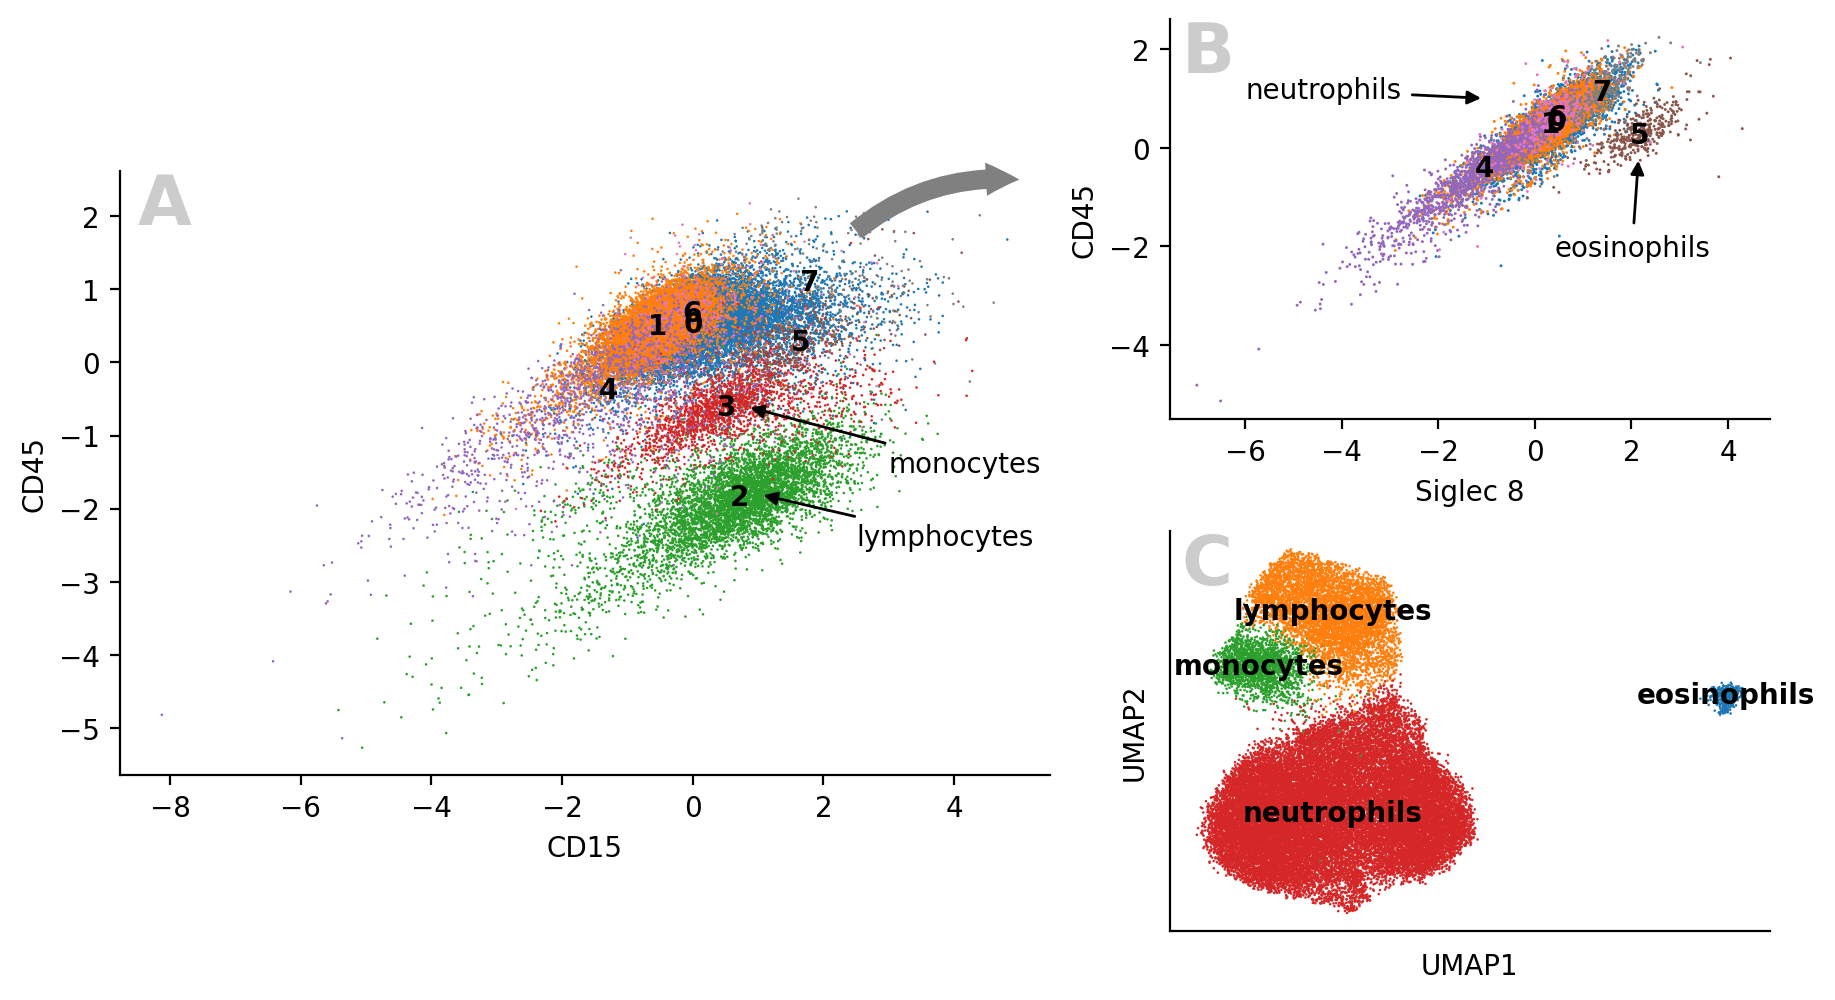

In [59]:
fig, ax = plt.subplots(dpi=200)
scanpy.pl.scatter(adata2, x="feat_sum_EGFP", y="feat_sum_APC", color="leiden", legend_loc="on data", ax=ax, show=False)
ax.annotate('monocytes', xy=(.8, -.6), xytext=(3, -1.5), arrowprops=dict(facecolor='black', arrowstyle="-|>"))
ax.annotate('lymphocytes', xy=(1, -1.8), xytext=(2.5, -2.5), arrowprops=dict(facecolor='black', arrowstyle="-|>"))
ax.text(s="A", x=0.02, y=1, fontsize=25, weight="heavy", alpha=0.2, transform=ax.transAxes, va="top")
ax.set_xlabel("CD15")
ax.set_ylabel("CD45")
ax.set_title("")

ax.annotate("", xytext=(2.5, 1.8), xy=(5, 2.5), arrowprops=dict(facecolor='grey', width=7, edgecolor="none", connectionstyle=ConnectionStyle("Arc3", rad=-0.2)))

ax2 = fig.add_axes([1, 0.57, 0.5, 0.5], zorder=1)
scanpy.pl.scatter(adata2[adata2.obs["cell type"].isin(['neutrophils', 'eosinophils'])], x="feat_sum_RPe", y="feat_sum_APC", color="leiden", legend_loc="on data", ax=ax2, show=False)
ax2.annotate('eosinophils', xy=(2.15, -.15), xytext=(.4, -2.2), arrowprops=dict(facecolor='black', arrowstyle="-|>"))
ax2.annotate('neutrophils', xy=(-1, 1), xytext=(-6, 1), arrowprops=dict(facecolor='black', arrowstyle="-|>"))
ax2.text(s="B", x=0.02, y=1, fontsize=25, weight="heavy", alpha=0.2, transform=ax2.transAxes, va="top")
ax2.set_title("")
ax2.set_ylabel("CD45")
ax2.set_xlabel("Siglec 8")

ax3 = fig.add_axes([1, -.07, 0.5, 0.5], zorder=1)
scanpy.pl.umap(adata2, color=["cell type"], legend_loc='on data', ax=ax3, show=False)
ax3.text(s="C", x=0.02, y=1, fontsize=25, weight="heavy", alpha=0.2, transform=ax3.transAxes, va="top")
ax3.set_title("")

seaborn.despine(fig)

plt.savefig(data_dir / "figures/cluster_annotation.png", bbox_inches='tight', pad_inches=0, dpi=200)

In [61]:
counts = adata2.obs["cell type"].value_counts().to_frame()
counts["fraction"] = counts["cell type"] / counts["cell type"].sum()
counts.columns = ["Count", "Fraction"]
print(counts.style.to_latex())

\begin{tabular}{lrr}
 & Count & Fraction \\
neutrophils & 26771 & 0.772835 \\
lymphocytes & 5576 & 0.160970 \\
monocytes & 1925 & 0.055572 \\
eosinophils & 368 & 0.010624 \\
\end{tabular}



## Neutrophils

In [161]:
adata_neut = adata2[adata2.obs["cell type"] == "neutrophils"].copy()

In [162]:
scanpy.pp.scale(adata_neut)
scanpy.tl.pca(adata_neut, svd_solver='arpack')
scanpy.pp.neighbors(adata_neut, n_neighbors=30, method="umap")

computing PCA
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)


In [165]:
scanpy.tl.leiden(adata_neut, resolution=0.5, key_added="leiden")

running Leiden clustering
    finished: found 6 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:12)


In [172]:
scanpy.tl.umap(adata_neut, min_dist=0, spread=0.5, random_state=0)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:26)


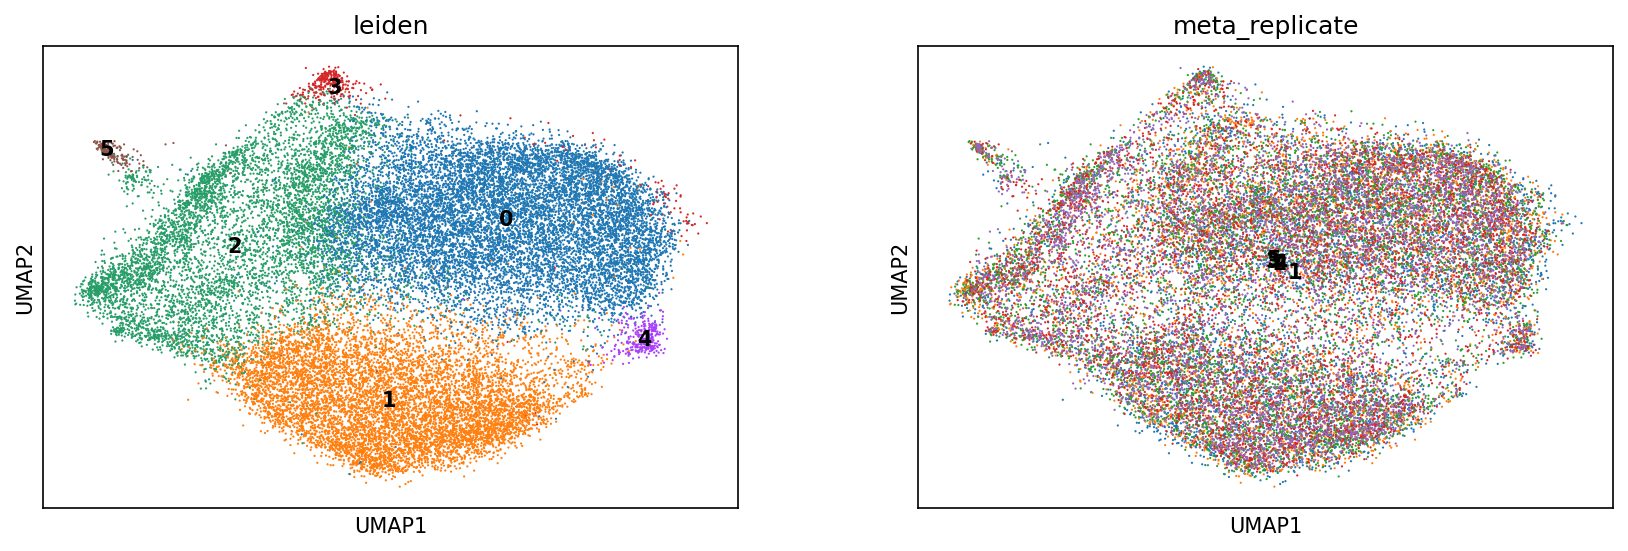

In [173]:
scanpy.pl.umap(adata_neut, color=["leiden", "meta_replicate"], legend_loc='on data')

In [174]:
scanpy.tl.dendrogram(adata_neut, groupby="leiden")

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


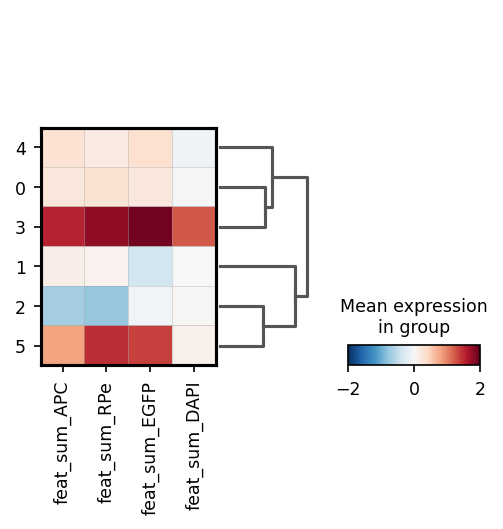

In [175]:
scanpy.pl.matrixplot(adata_neut, markers, groupby='leiden', dendrogram=True, vmin=-2, vmax=2, cmap='RdBu_r')

In [185]:
adata_neut.obs.groupby("leiden").size() / len(adata_neut)

leiden
0    0.418559
1    0.304617
2    0.242902
3    0.013748
4    0.012552
5    0.007621
dtype: float64

## Lymphocytes

In [177]:
adata_lymph = adata2[adata2.obs["cell type"] == "lymphocytes"].copy()

In [178]:
scanpy.pp.scale(adata_lymph)
scanpy.tl.pca(adata_lymph, svd_solver='arpack')
scanpy.pp.neighbors(adata_lymph, n_neighbors=30, method="umap")

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


In [179]:
scanpy.tl.leiden(adata_lymph, resolution=0.5, key_added="leiden")

running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [180]:
scanpy.tl.umap(adata_lymph, min_dist=0, spread=0.5, random_state=0)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:13)


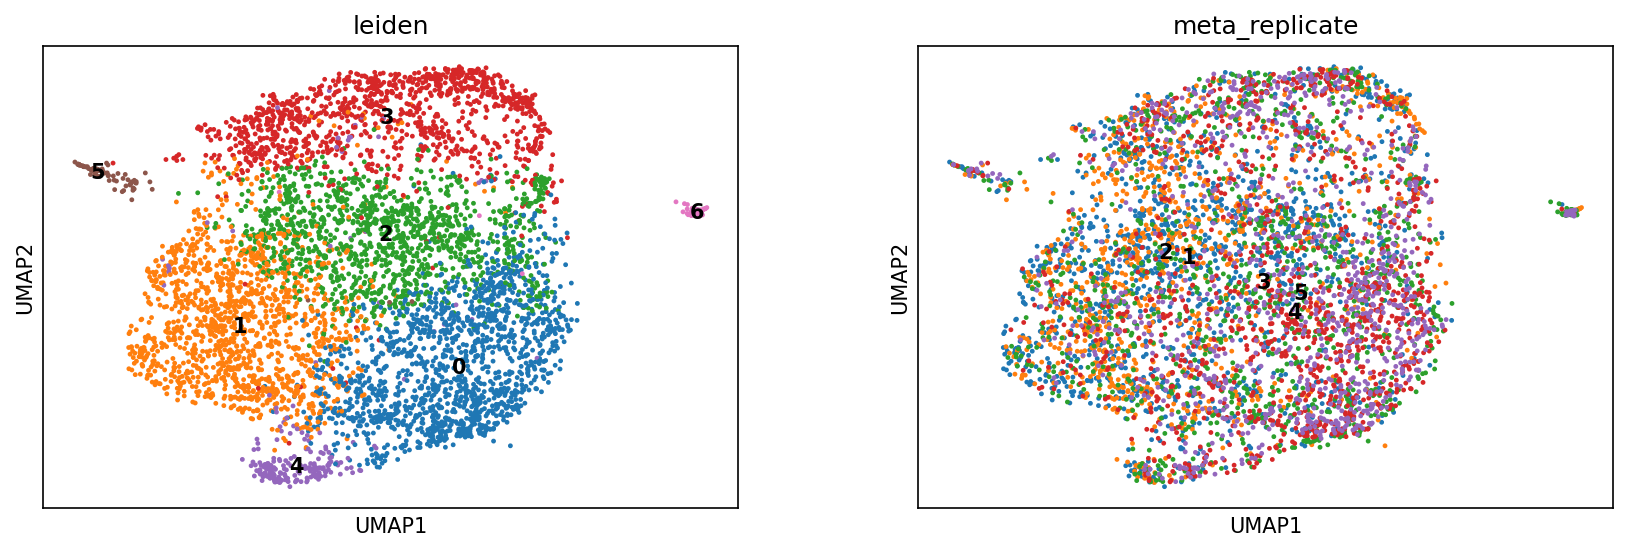

In [181]:
scanpy.pl.umap(adata_lymph, color=["leiden", "meta_replicate"], legend_loc='on data')

In [182]:
scanpy.tl.dendrogram(adata_lymph, groupby="leiden")

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


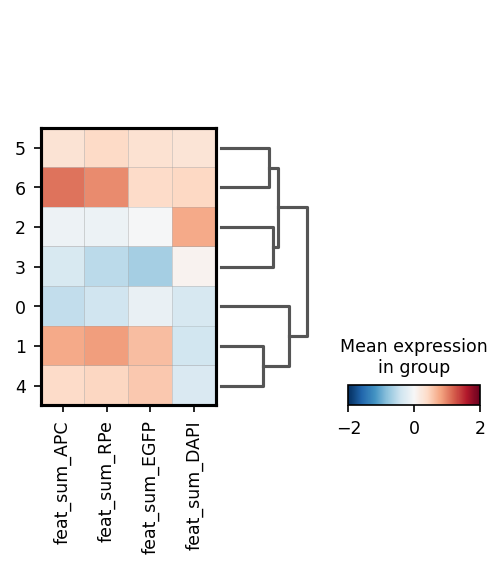

In [183]:
scanpy.pl.matrixplot(adata_lymph, markers, groupby='leiden', dendrogram=True, vmin=-2, vmax=2, cmap='RdBu_r')

In [184]:
adata_lymph.obs.groupby("leiden").size()

leiden
0    1463
1    1365
2    1241
3    1153
4     218
5      89
6      74
dtype: int64